## Toy Model 1: 2 spatial modes with different oscillating frequencies

In [1]:
import sys

sys.path.insert(0, "/kaggle/input/scriptsmrcae/src")

In [2]:
!mkdir data
!mkdir result
!mkdir model
!mkdir data/npy
!mkdir result/toy1
!mkdir model/toy1

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [3]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('/kaggle/input/scriptsmrcae/src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net

## Simulation 

In [4]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

In [5]:
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

In [6]:
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 500)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

In [7]:
# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
print(Phi.shape)

np.save("/kaggle/working/data/npy/toy1.npy", scaled_Phi.T)

(127, 127, 500)


## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [8]:
# init model & load data
data_path = '/kaggle/working/data/npy/toy1.npy'
model_path = '/kaggle/working/model/toy1/'
result_path = '/kaggle/working/result/toy1/'

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [9]:
# training
archs = [[1,2,3,4],[1,2,3,4],[1,3,5,7]]
tols = [0.001, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=5000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)

*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/5000]
[training set] local: 0.0027/0.0302/0.0164, global: 0.0027/0.0302/0.0164
[validation set] local: 0.0026/0.0306/0.0166, global: 0.0026/0.0306/0.0166
epoch [500/5000]:
[training set] local: 0.0005/0.0072/0.0039, global: 0.0005/0.0101/0.0053
[validation set] local: 0.0005/0.0087/0.0046, global: 0.0005/0.0122/0.0064
epoch [1000/5000]:
[training set] local: 0.0000/0.0027/0.0014, global: 0.0000/0.0071/0.0036
[validation set] local: 0.0000/0.0031/0.0016, global: 0.0000/0.0079/0.0040
epoch [1500/5000]:
[training set] local: 0.0000/0.0025/0.0013, global: 0.0000/0.0067/0.0034
[validation set] local: 0.0000/0.0028/0.0014, global: 0.0000/0.0072/0.0036
epoch [2000/5000]:
[training set] local: 0.0001/0.0024/0.0012, global: 0.0000/0.00

CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_Conv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_Conv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L1_deConv_1): Conv2dBlock(
    (activation): Sequential()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3

## Results

In [10]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_1
model_L1_0
model_L1_1
model_L1_2
model_L2_0
model_L2_1
model_L2_2
model_L2_3


dict_keys(['0', '1'])
dict_keys(['0', '1', '2'])
dict_keys(['0', '1', '2', '3'])


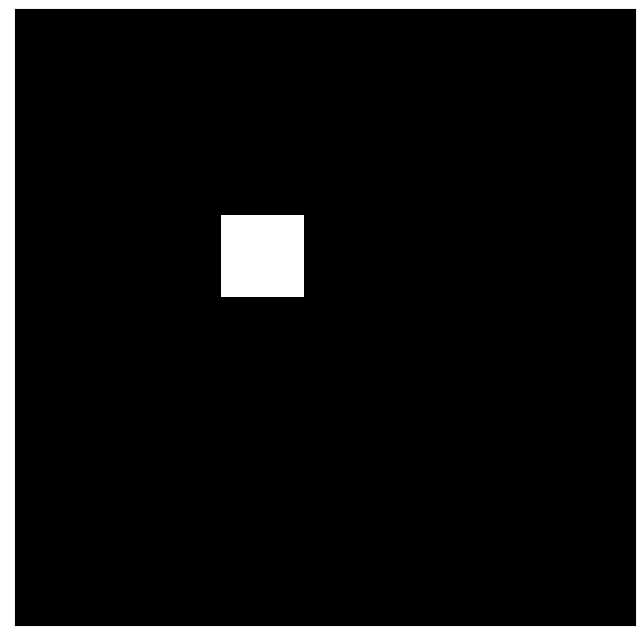

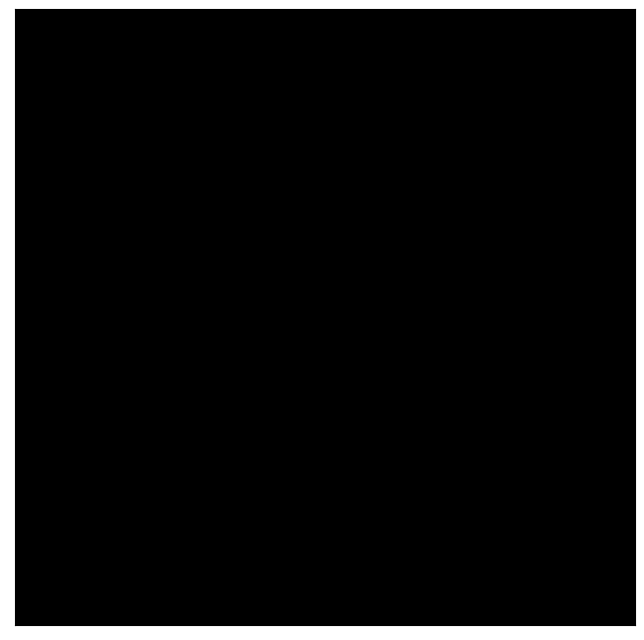

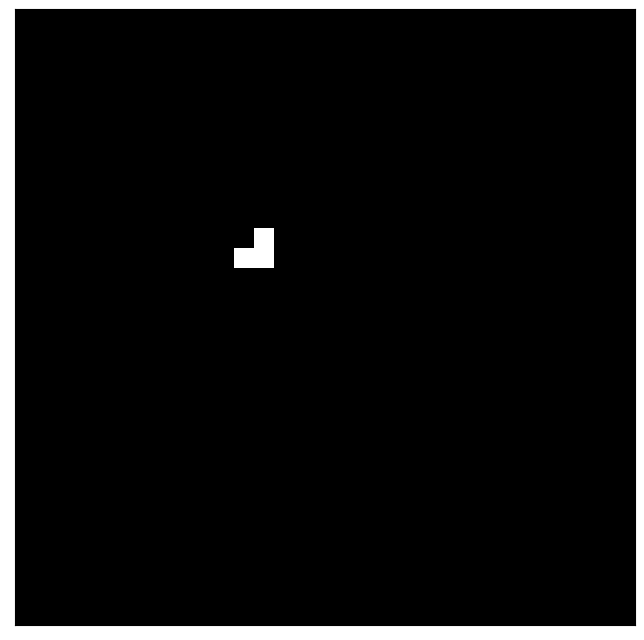

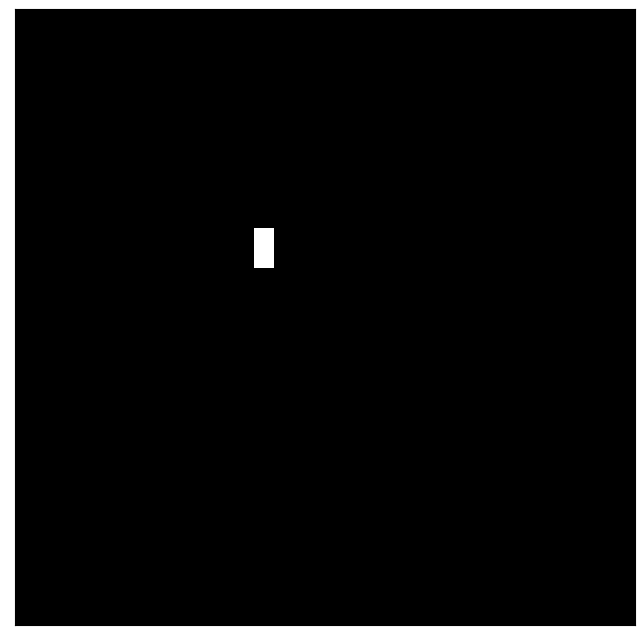

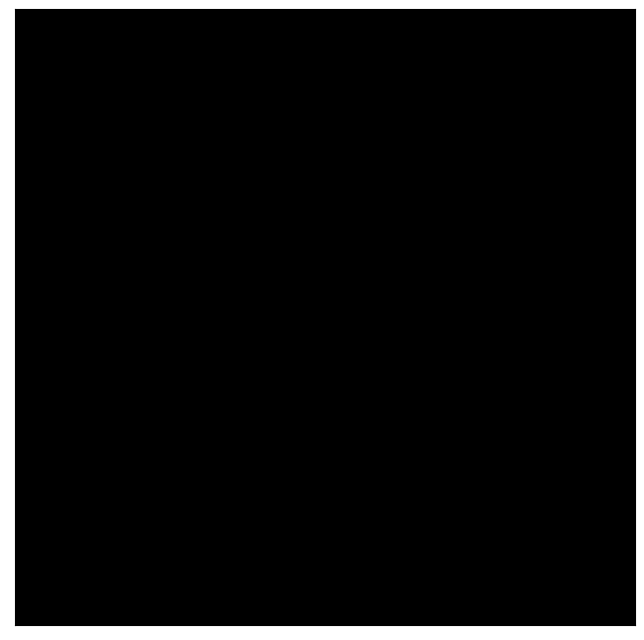

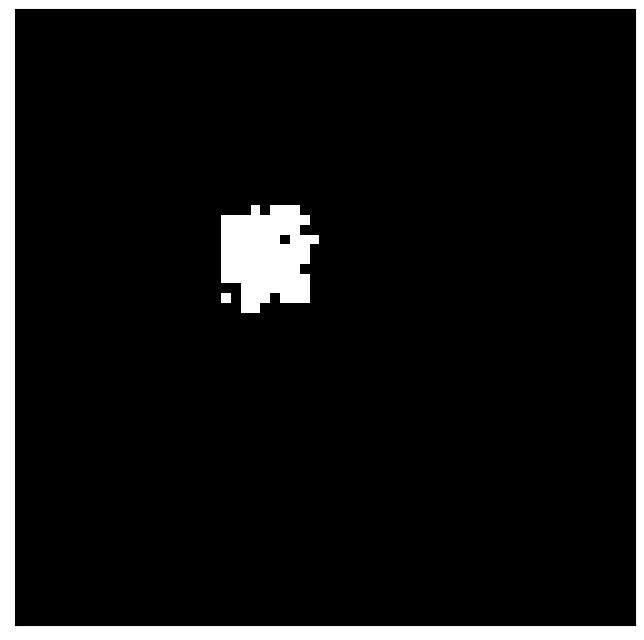

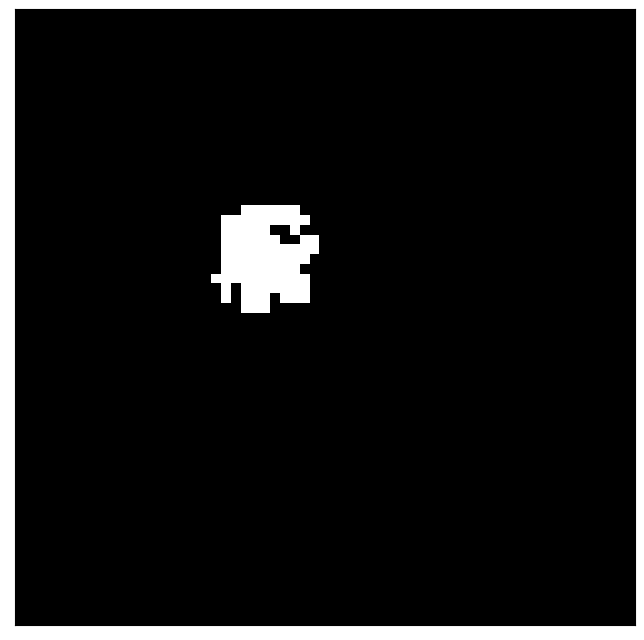

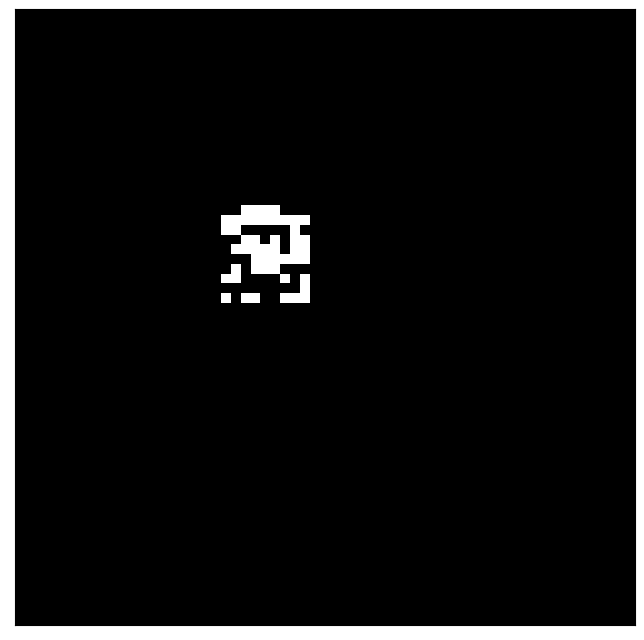

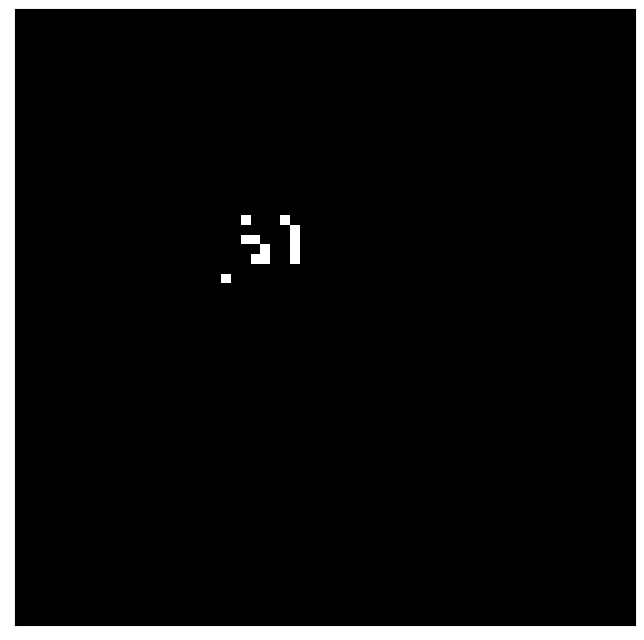

In [ ]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

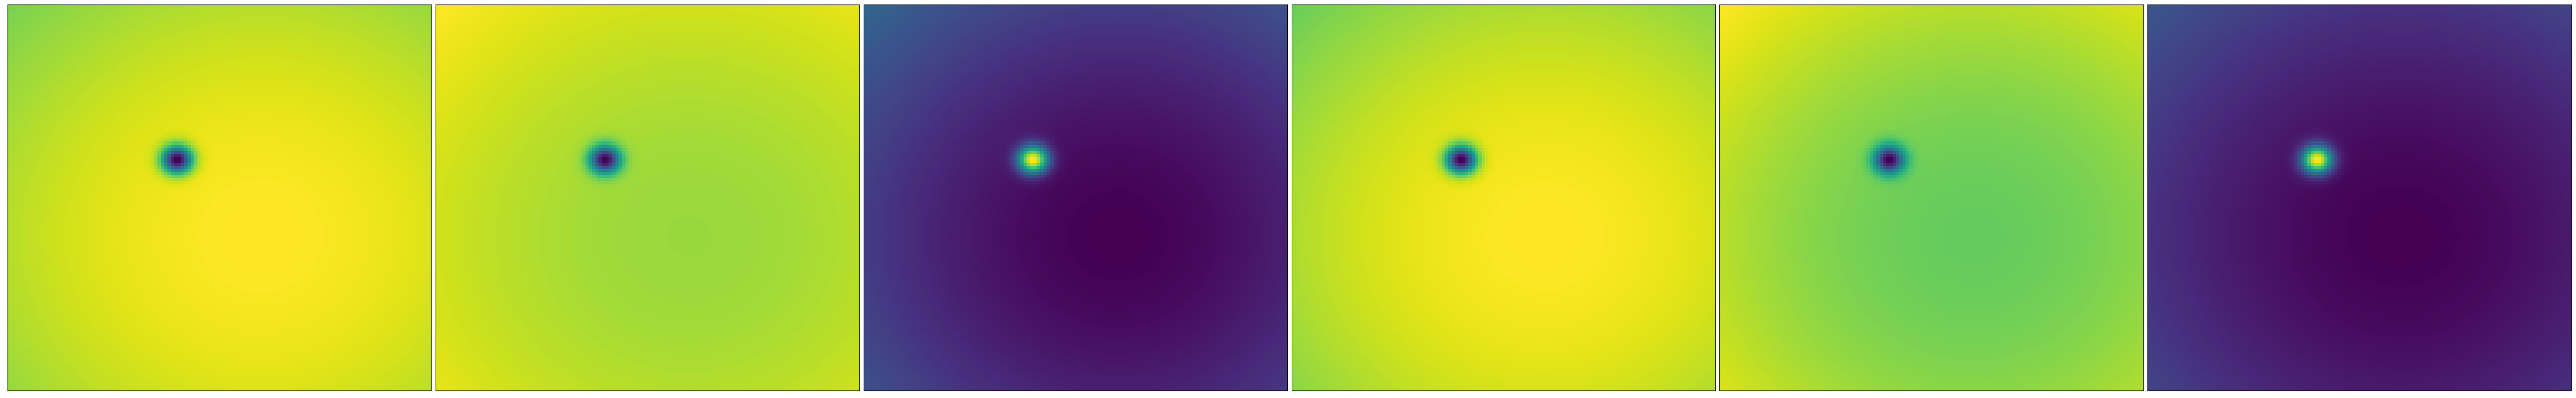

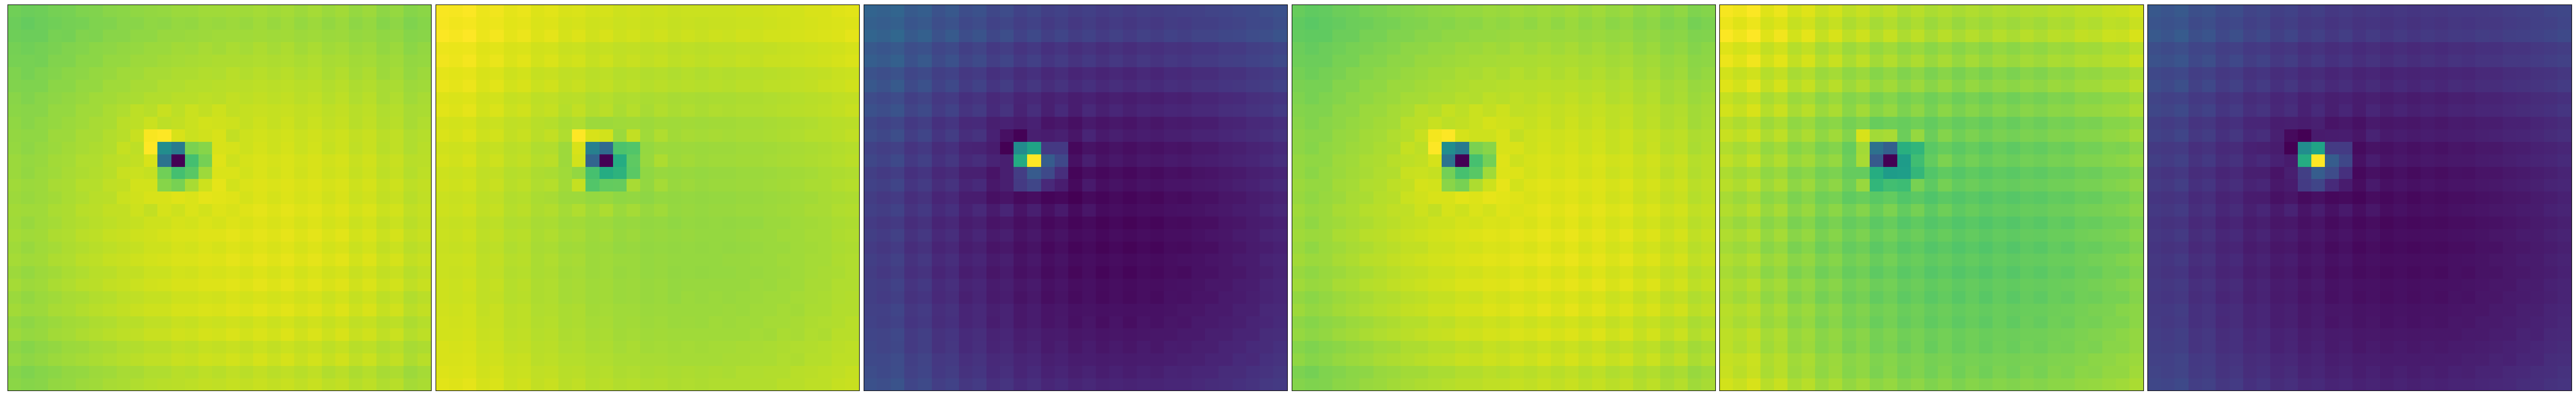

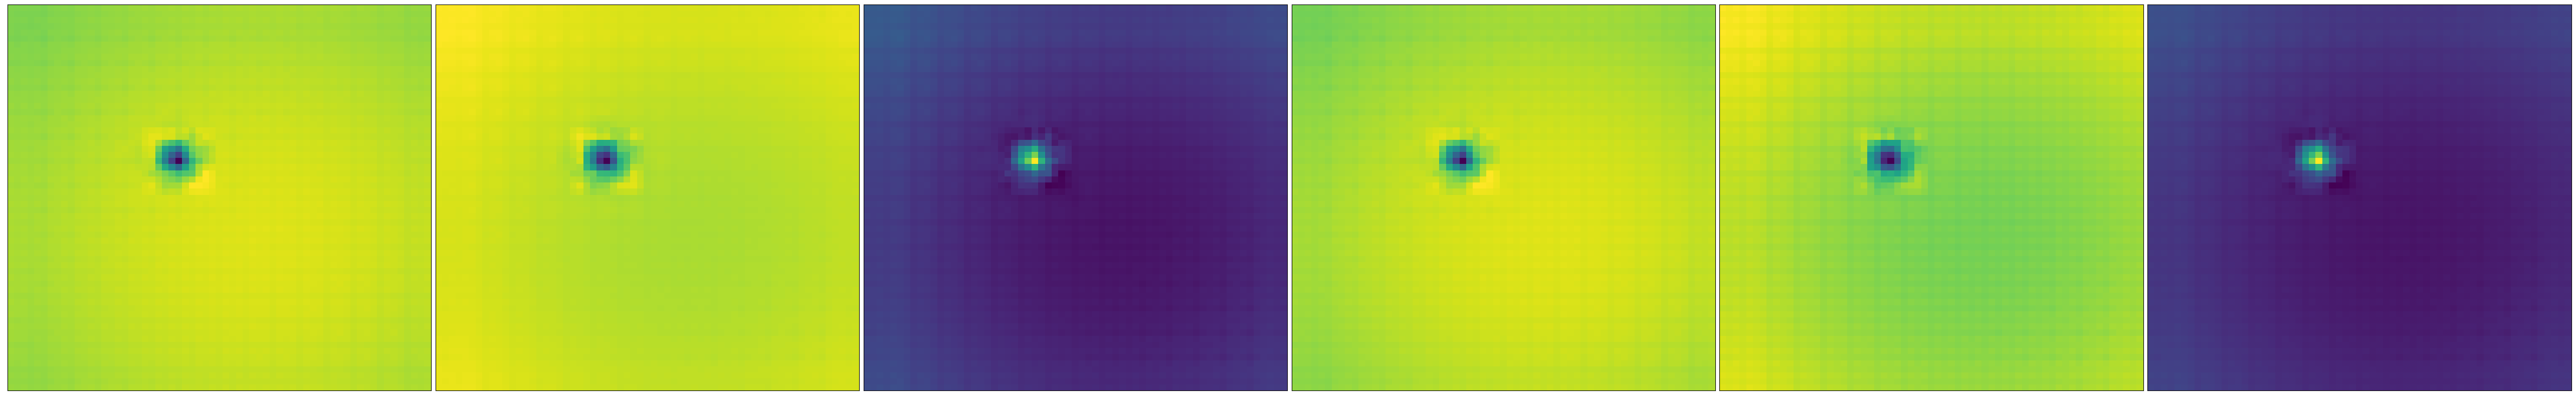

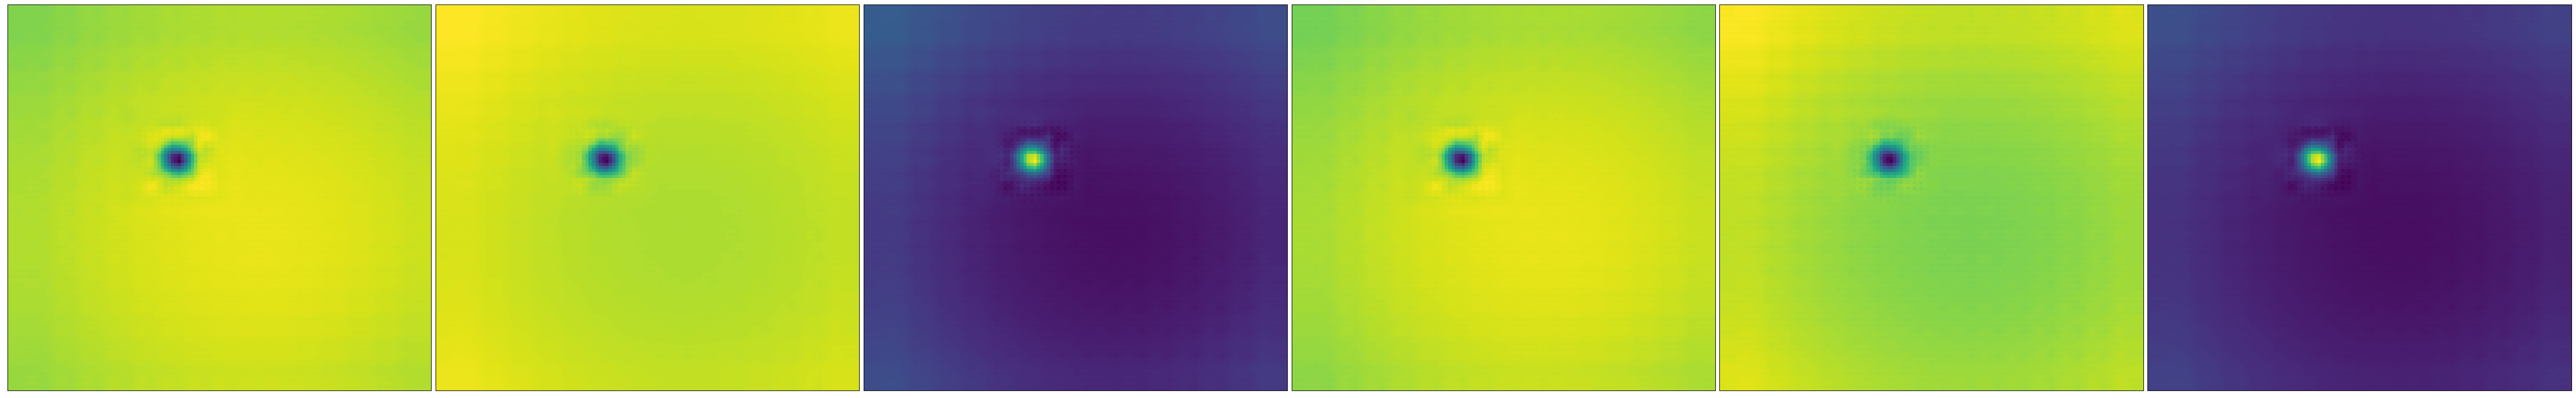

In [ ]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

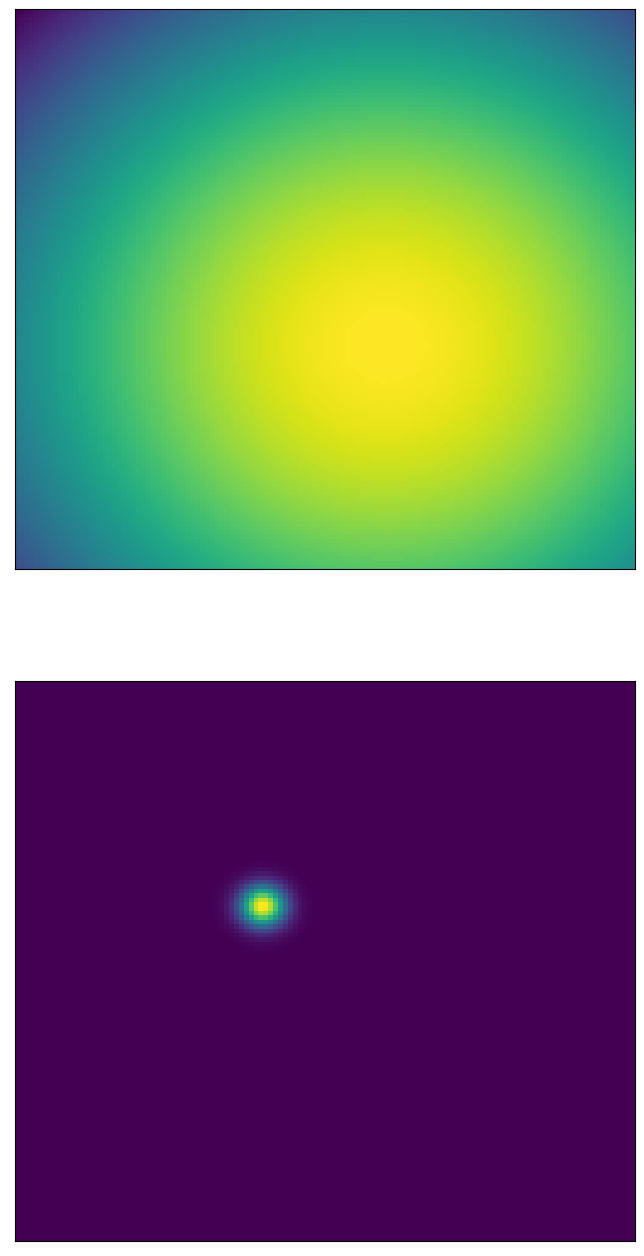

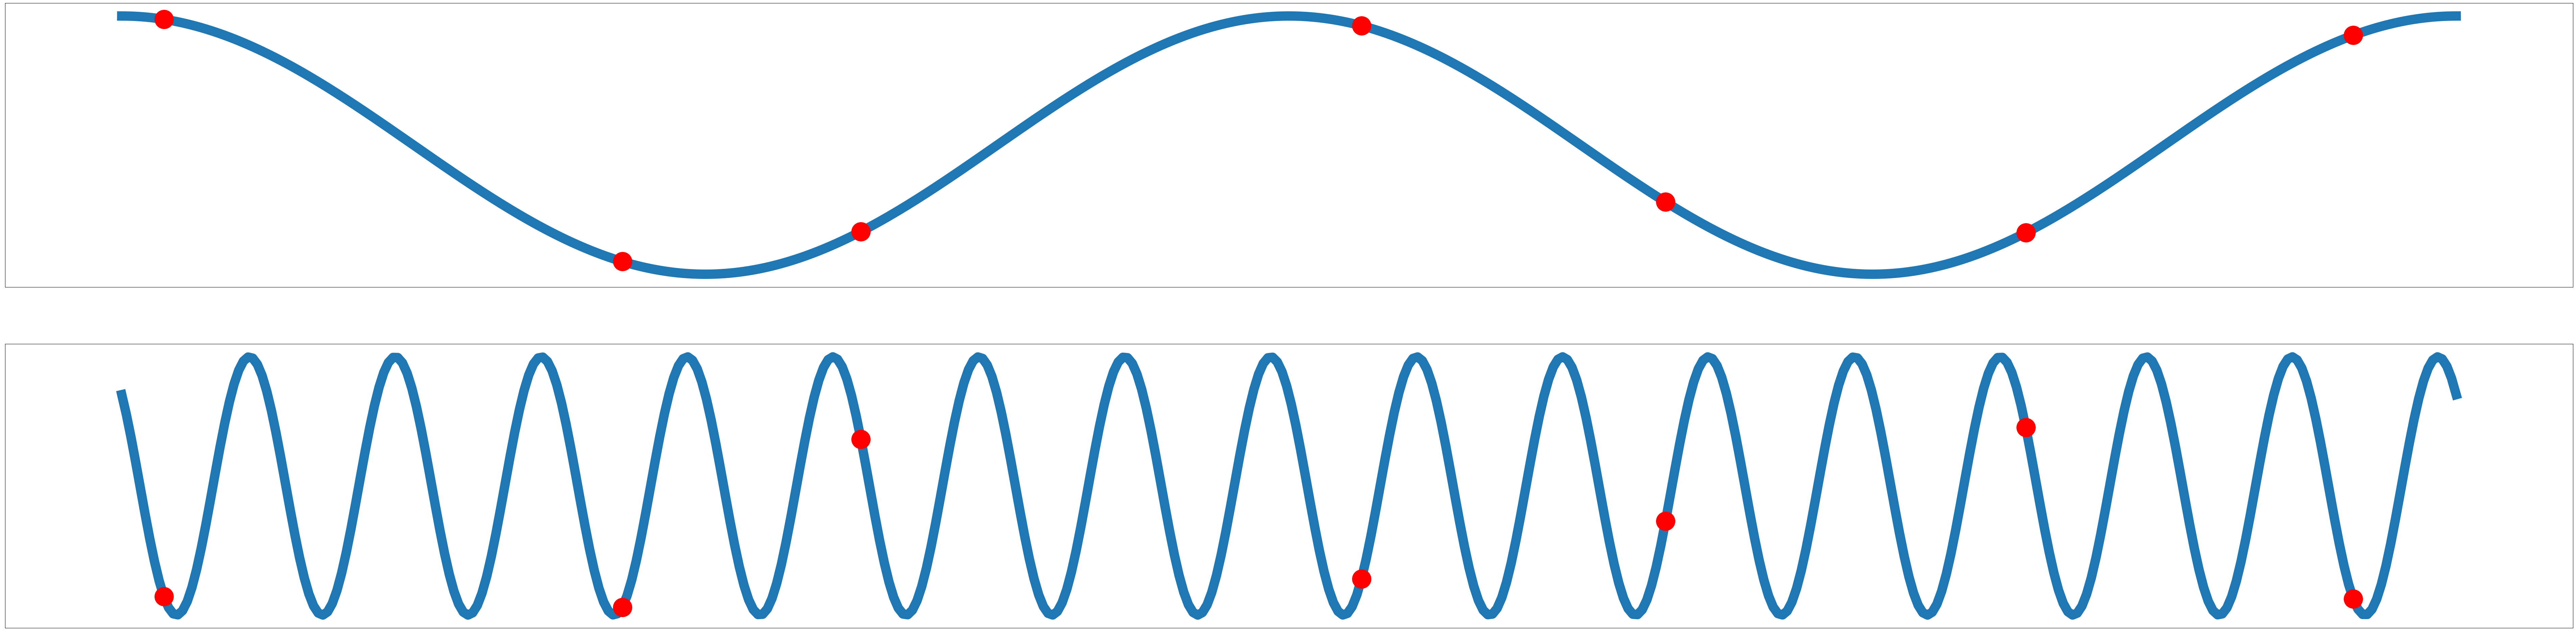

In [ ]:
fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[inds[::n_step]], np.cos(w0*t[inds[::n_step]]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[inds[::n_step]], np.cos(w1*t[inds[::n_step]] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [ ]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

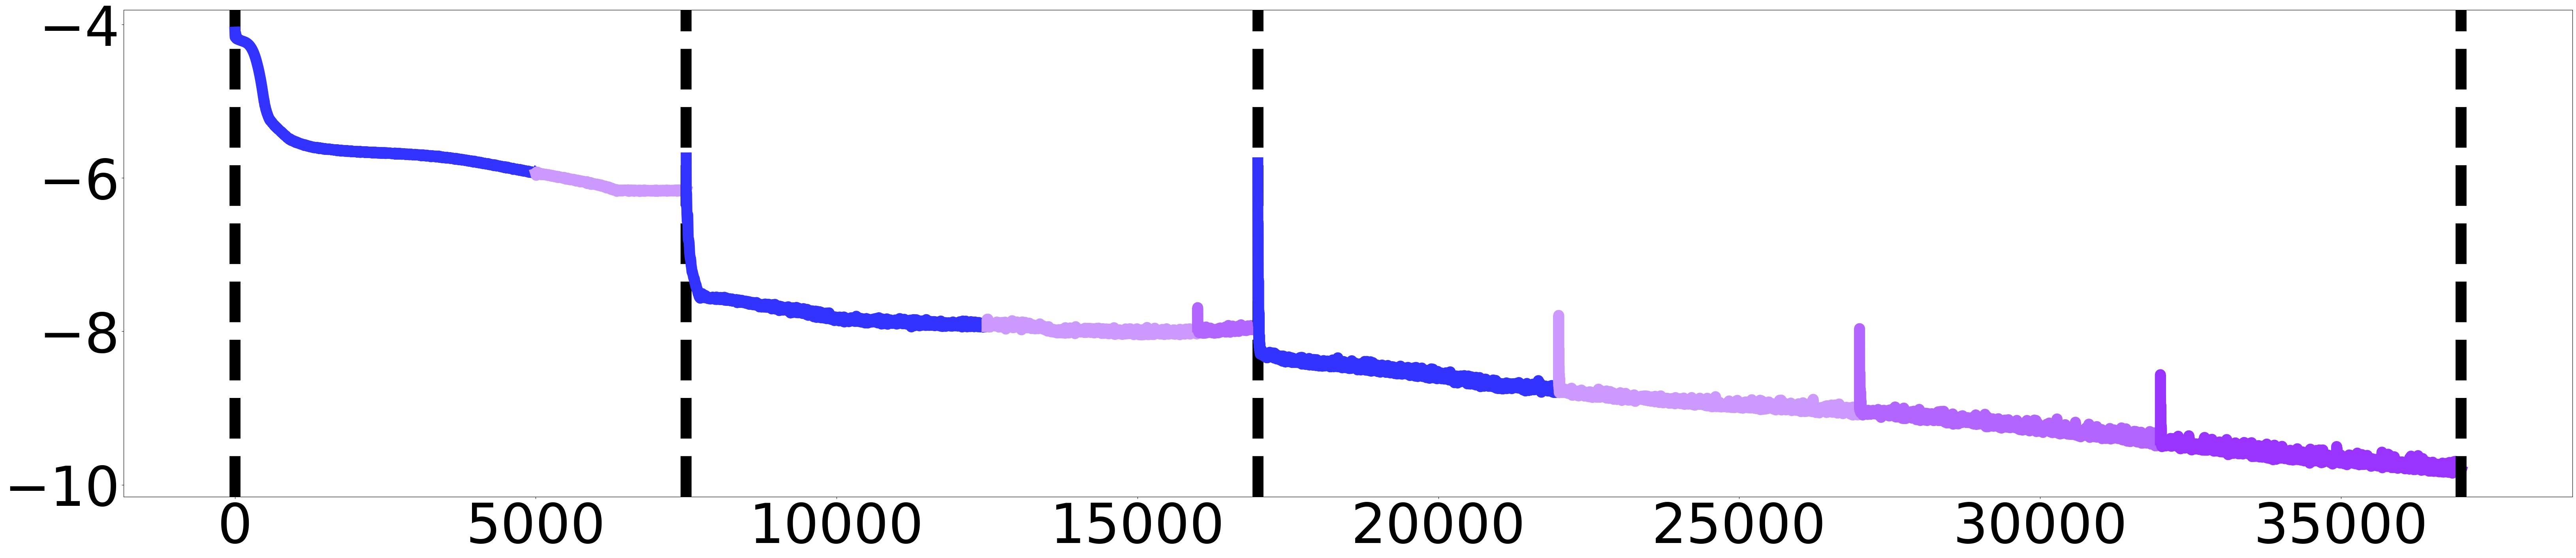

In [ ]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))